In [0]:
import pandas as pd
import warnings
import numpy
import gensim
from gensim import corpora, models
from gensim.models import word2vec

import nltk
import re
import csv
from nltk.corpus import stopwords
import numpy as np
from gensim.models import Doc2Vec
from gensim.models.doc2vec import LabeledSentence
from gensim.models.doc2vec import TaggedDocument
from gensim.test.utils import common_texts
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df=pd.read_csv("/content/preprocessed.csv",encoding = 'unicode_escape')
df= df.loc[:, ~df.columns.str.contains('^Unnamed')]
df.head()

,problems,keywords,urls,contents,target
0,Understand the virtual banking landscape of So...,"virtual banks, south korea, k bank, kakao bank...",https://krw.currencyrate.today/usd/18064,\nThe page provides the exchange rate of 18064...,valid
1,Understand the depth of Covid-19 crisis in a c...,"virus, epidemic, outbreak, company performance...",https://krw.currencyrate.today/usd/18064,Convert currency 18064 KRW to USD. How much is...,valid
2,What is webank china? I need to understand the...,"Webank, China, Technology, virtual bank, weban...",https://krw.currencyrate.today/usd/18064,\nSouth Korean Won\n\n18064 KRW\n=\n14.91 USD\...,valid
3,What is mybank china? I need to understand the...,"Mybank, China, Technology, virtual bank, Myban...",https://krw.currencyrate.today/usd/18064,\n ?18064.00 = $14.91,valid
4,NaN,NaN,https://krw.currencyrate.today/usd/18064,\n\n Inverse: 18064.00 USD = 21889955.2...,valid


In [91]:
data=df.drop(['problems','urls'],axis=1)
data.head()

,keywords,contents,target
0,"virtual banks, south korea, k bank, kakao bank...",\nThe page provides the exchange rate of 18064...,valid
1,"virus, epidemic, outbreak, company performance...",Convert currency 18064 KRW to USD. How much is...,valid
2,"Webank, China, Technology, virtual bank, weban...",\nSouth Korean Won\n\n18064 KRW\n=\n14.91 USD\...,valid
3,"Mybank, China, Technology, virtual bank, Myban...",\n ?18064.00 = $14.91,valid
4,NaN,\n\n Inverse: 18064.00 USD = 21889955.2...,valid


Preprocessing 1 ---
removing special character by regex

In [0]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}

In [0]:
def content_cleaner(text):
    newString = re.sub('"','', str(text))
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    newString = newString.lower()
    tokens=newString.split()
    newString=''
    
    for i in tokens:
        if len(i)>1:                                 
            newString=newString+i+' '  
            #print(newString)
    return newString

In [0]:
#Call the above function
cleaned_content = []
for t in data['contents']:
    cleaned_content.append(content_cleaner(t))


data['cleaned_content']=cleaned_content

#df.dropna(axis=0,inplace=True)

In [94]:
data['cleaned_content']

0       the page provides the exchange rate of south k...
1       convert currency krw to usd how much is south ...
2                     south korean won krw usd us dollar 
3                                                        
4                inverse usd krw selling krw you get usd 
                              ...                        
2079    two non financial services entities korea fede...
2080    with its shareholding structure reshuffled tos...
2081    analysts say that toss bank has better chance ...
2082    at the same time toss bank does not have much ...
2083    sign up for our email newsletter and keep up t...
Name: cleaned_content, Length: 2084, dtype: object

In [95]:
data['keywords']

0       virtual banks, south korea, k bank, kakao bank...
1       virus, epidemic, outbreak, company performance...
2       Webank, China, Technology, virtual bank, weban...
3       Mybank, China, Technology, virtual bank, Myban...
4                                                     NaN
                              ...                        
2079    Mybank, China, Technology, virtual bank, Myban...
2080    Mybank, China, Technology, virtual bank, Myban...
2081    Mybank, China, Technology, virtual bank, Myban...
2082    Mybank, China, Technology, virtual bank, Myban...
2083    Mybank, China, Technology, virtual bank, Myban...
Name: keywords, Length: 2084, dtype: object

In [96]:
data = data.dropna(how="any")
data

,keywords,contents,target,cleaned_content
0,"virtual banks, south korea, k bank, kakao bank...",\nThe page provides the exchange rate of 18064...,valid,the page provides the exchange rate of south k...
1,"virus, epidemic, outbreak, company performance...",Convert currency 18064 KRW to USD. How much is...,valid,convert currency krw to usd how much is south ...
2,"Webank, China, Technology, virtual bank, weban...",\nSouth Korean Won\n\n18064 KRW\n=\n14.91 USD\...,valid,south korean won krw usd us dollar
3,"Mybank, China, Technology, virtual bank, Myban...",\n ?18064.00 = $14.91,valid,
5,"virtual banks, south korea, k bank, kakao bank...",\nThe page provides the exchange rate of 18064...,valid,the page provides the exchange rate of south k...
...,...,...,...,...
2079,"Mybank, China, Technology, virtual bank, Myban...","Two non-financial services entities, Korea Fed...",valid,two non financial services entities korea fede...
2080,"Mybank, China, Technology, virtual bank, Myban...","With its shareholding structure reshuffled, To...",valid,with its shareholding structure reshuffled tos...
2081,"Mybank, China, Technology, virtual bank, Myban...",Analysts say that Toss Bank has a better chanc...,valid,analysts say that toss bank has better chance ...
2082,"Mybank, China, Technology, virtual bank, Myban...","At the same time, Toss Bank doesn't have much ...",valid,at the same time toss bank does not have much ...


In [97]:
dataset=data.drop(['contents'],axis=1)
dataset.head()

,keywords,target,cleaned_content
0,"virtual banks, south korea, k bank, kakao bank...",valid,the page provides the exchange rate of south k...
1,"virus, epidemic, outbreak, company performance...",valid,convert currency krw to usd how much is south ...
2,"Webank, China, Technology, virtual bank, weban...",valid,south korean won krw usd us dollar
3,"Mybank, China, Technology, virtual bank, Myban...",valid,
5,"virtual banks, south korea, k bank, kakao bank...",valid,the page provides the exchange rate of south k...


In [11]:
import gensim.downloader as api
word_vectors = api.load("glove-wiki-gigaword-100")

[==============================================----] 94.0% 120.4/128.1MB downloaded


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [98]:
# build corpus
def build_corpus(data):
    "Creates a list of lists containing words from each sentence"
    corpus = []
    for col in ['keywords','cleaned_content']:
        for sentence in data[col].iteritems():
            word_list = sentence[1].split(" ")
            corpus.append(word_list)
            
    return corpus

corpus = build_corpus(data)        
corpus[0:2]

[['virtual',
  'banks,',
  'south',
  'korea,',
  'k',
  'bank,',
  'kakao',
  'bank,',
  'toss,',
  'funding',
  'in',
  'virtual',
  'banks,',
  'banking',
  'population,',
  'digital',
  'banking',
  'users,',
  'smartphone',
  'users,',
  '',
  'digital',
  'loans,',
  'online',
  'deposits,',
  'digital',
  'only',
  'banks,',
  'virtual',
  'bank',
  'license,',
  'FSC',
  'south',
  'korea,',
  'virtual',
  'bank',
  'valuation'],
 ['virus,',
  'epidemic,',
  'outbreak,',
  'company',
  'performance,',
  'healthcare,',
  'aviation,',
  'hospitality,',
  'digital,',
  'performance,',
  'stock',
  'price,',
  'IPO,',
  '',
  'company',
  'action,',
  'company',
  'decision,',
  'effect,',
  'affect,',
  'adversity']]

In [99]:
model = word2vec.Word2Vec(corpus, size=100, window=20, min_count=100, workers=4)
model.wv['virtual']

array([ 0.00846873,  0.15773775, -0.02375555, -0.02127615, -0.31966257,
        0.0852065 ,  0.04139773,  0.32397214,  0.08908609, -0.02886861,
        0.21472143,  0.23129393,  0.17011097, -0.0135476 ,  0.5359629 ,
       -0.10997023, -0.30810177, -0.20221125,  0.13156343, -0.22712748,
       -0.5662911 , -0.0363087 , -0.19879039, -0.4314417 ,  0.10844818,
        0.11831441,  0.21893142,  0.23890898,  0.530087  , -0.09409627,
       -0.16097817, -0.35371396, -0.5039678 , -0.44718343,  0.12414455,
        0.7808135 , -0.11955527, -0.25844818,  0.3982087 ,  0.07684102,
       -0.00143677,  0.03640412,  0.05006085, -0.46664798, -0.0259706 ,
        0.13817517, -0.0383306 ,  0.04638405,  0.40279105, -0.22708124,
        0.01460063,  0.00600673, -0.5455545 , -0.07706451, -0.54086405,
        0.06268571, -0.16882837, -0.5023696 , -0.3637046 ,  0.13852768,
       -0.4115392 , -0.6835466 , -0.43654513,  0.3307315 ,  0.00243692,
        0.03558778,  0.8987395 ,  0.72129726,  0.21848509, -0.18

In [0]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


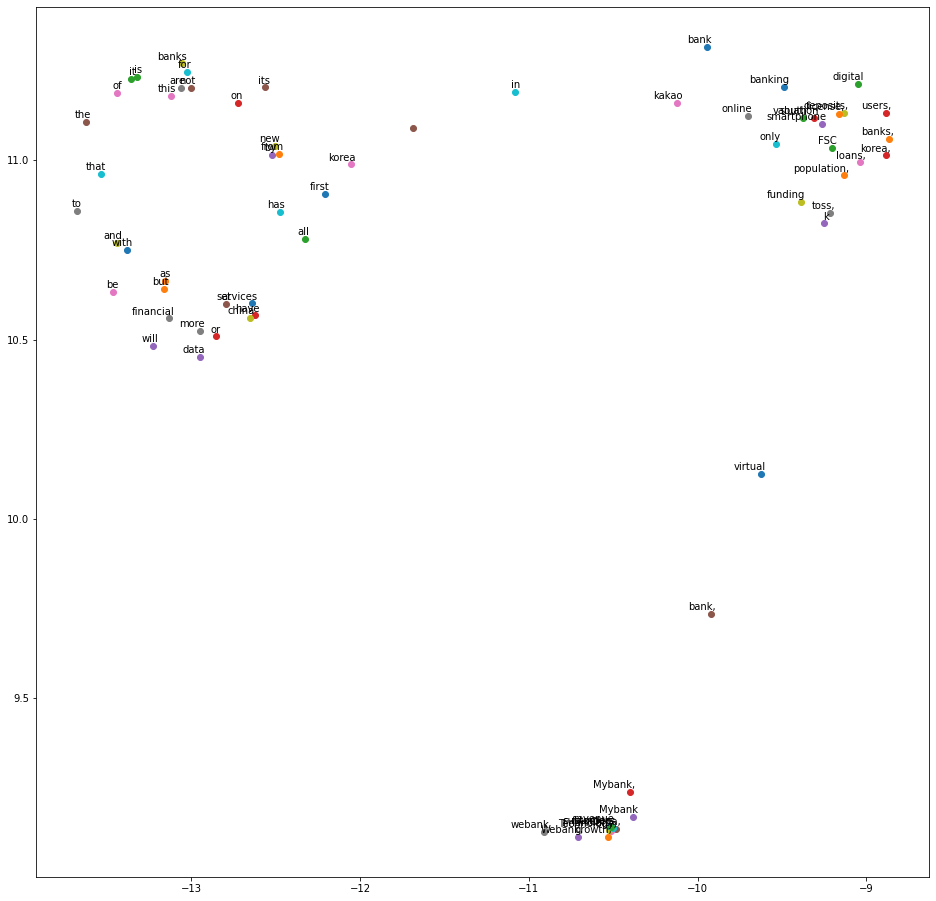

In [101]:
tsne_plot(model)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


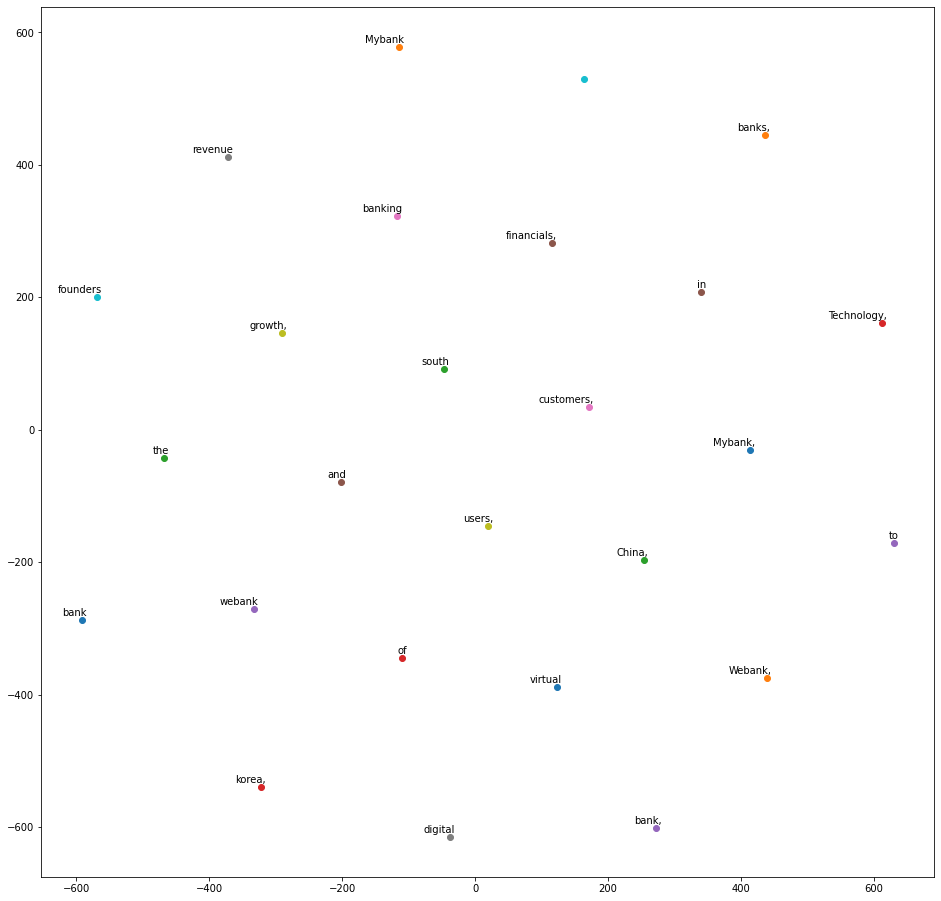

In [102]:
model = word2vec.Word2Vec(corpus, size=100, window=20, min_count=500, workers=4)
tsne_plot(model)

In [103]:
model.most_similar('virtual')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('bank,', 0.9641432762145996),
 ('korea,', 0.8033844232559204),
 ('banks,', 0.7928144931793213),
 ('users,', 0.7838109731674194),
 ('digital', 0.7375202775001526),
 ('banking', 0.7144102454185486),
 ('south', 0.7098211646080017),
 ('Mybank', 0.6508842706680298),
 ('Mybank,', 0.6380349397659302),
 ('bank', 0.6379178762435913)]

In [118]:
similarity = word_vectors.wmdistance(dataset.keywords[1], dataset.cleaned_content[24])
print("score between keywords and contents: {:.6f}".format(similarity))


score between keywords and contents: 1.344963


In [119]:
a=print(dataset.keywords[1])
b=print(dataset.cleaned_content[24])


virus, epidemic, outbreak, company performance, healthcare, aviation, hospitality, digital, performance, stock price, IPO,  company action, company decision, effect, affect, adversity
what is it that is making consumers so enthusiastic about kakao bank replies on sns and on internet investment boards show the bank appeal lies in its cheap prices modern interface and convenience 
